### Dataset Preparation
***Took reference from papers***
- Development of the Combined Assessment of Risk Encountered in Surgery (CARES) surgical risk calculator for prediction of postsurgical mortality and need for intensive care unit admission risk: a single-center retrospective study
- ...

In [ ]:
pip install duckdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 600.1 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

In [1]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import duckdb
# from duckdb import sql

In [2]:
# Import dataset
data = pd.read_csv("../data/CARES_dataset_clean.csv")

In [3]:
data.head()

,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,DaysbetweenDeathandoperation,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop,AnaestypeCategory,...,RaceCategory,CVARCRICategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,GradeofKidneyCategory,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,FEMALE,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,GA,...,Chinese,no,no,no,no,no,NaN,NaN,I,no
1,FEMALE,NaN,none,NaN,NaN,0.0,0.0,0.0,0.0,GA,...,Chinese,no,no,no,no,no,NaN,<= 15.7,I,no
2,FEMALE,NaN,mild,152.538570,NaN,0.0,0.0,0.0,0.0,GA,...,Chinese,no,no,no,no,no,G1,<= 15.7,I,no
3,MALE,NaN,moderate/severe,117.231496,NaN,0.0,1.0,0.0,1.0,GA,...,Chinese,no,no,no,no,no,G1,<= 15.7,I,no
4,MALE,0.0,mild,98.651255,59.0,0.0,0.0,0.0,0.0,GA,...,Chinese,no,no,no,no,no,G1,>15.7,II,no


In [4]:
len(data)

90785

In [5]:
data.columns

Index(['GENDER', 'RCRI score', 'Anemia category', 'PreopEGFRMDRD',
       'DaysbetweenDeathandoperation', 'Preoptransfusionwithin30days',
       'Intraop', 'Postopwithin30days', 'Transfusionintraandpostop',
       'AnaestypeCategory', 'PriorityCategory',
       'TransfusionIntraandpostopCategory', 'AGEcategory', 'Mortality',
       'thirtydaymortality', 'SurgRiskCategory', 'RaceCategory',
       'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory',
       'DMinsulinRCRICategory', 'CreatinineRCRICategory',
       'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h'],
      dtype='object')

#### Dataset Preparation

In [28]:
# Define target column for correlation analysis
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality']
target_var = 'ICUAdmgt24h'
target_value = 'yes'
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = ['GENDER', 'Anemia category', 'AnaestypeCategory', 'PriorityCategory', 'TransfusionIntraandpostopCategory', 'AGEcategory', 'SurgRiskCategory', \
           'RaceCategory', 'CVARCRICategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'GradeofKidneyCategory', 'RDW15.7', 'ASAcategorybinned']

In [29]:
numerical_cols

['RCRI score',
 'PreopEGFRMDRD',
 'DaysbetweenDeathandoperation',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Postopwithin30days',
 'Transfusionintraandpostop']

In [8]:
data['ICUAdmgt24h'].value_counts()

ICUAdmgt24h
no     89521
yes     1264
Name: count, dtype: int64

In [9]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90785 entries, 0 to 90784
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             90785 non-null  object 
 1   RCRI score                         63361 non-null  float64
 2   Anemia category                    86747 non-null  object 
 3   PreopEGFRMDRD                      79955 non-null  float64
 4   DaysbetweenDeathandoperation       5595 non-null   float64
 5   Preoptransfusionwithin30days       90785 non-null  float64
 6   Intraop                            90785 non-null  float64
 7   Postopwithin30days                 90785 non-null  float64
 8   Transfusionintraandpostop          90785 non-null  float64
 9   AnaestypeCategory                  90785 non-null  object 
 10  PriorityCategory                   90785 non-null  object 
 11  TransfusionIntraandpostopCategory  90785 non-null  obj

#### Correlations for Categorical Variables

In [24]:
def correlation_counts(data, cat_cols, target_var='ICUAdmgt24h'):
    """
    Compute and visualize the proportion of each category for categorical variables where target_var equals target_value.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    cat_cols (list): List of categorical columns to analyze.
    target_var (str): The target variable name. Default is 'ICUAdmgt24h'.
    target_value (str): The target value to compute proportions for. Default is 'yes'.

    Returns:
    None
    """
    for col in cat_cols:
        if col in data.columns:
            # Compute the proportions
            total_counts = data[col].value_counts()
            yes_counts = data[data[target_var] == target_value][col].value_counts()
            proportions = yes_counts / total_counts
            proportions = proportions.fillna(0)  # Fill NaN values with 0
            
            print(f"Proportions for {col} when {target_var} is '{target_value}':\n{proportions}\n")
            
            # Plot the proportions
            plt.figure(figsize=(10, 6))
            sns.barplot(x=proportions.index, y=proportions.values)
            plt.title(f'Proportion of {col} when {target_var} is "{target_value}"')
            plt.ylabel('Proportion')
            plt.xlabel(col)
            plt.ylim(0, proportions.max() + 0.05)  # Adjust y-axis scale for better visibility
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column {col} is not in the dataframe.")

Proportions for GENDER when ICUAdmgt24h is 'yes':
GENDER
FEMALE    0.009834
MALE      0.018656
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


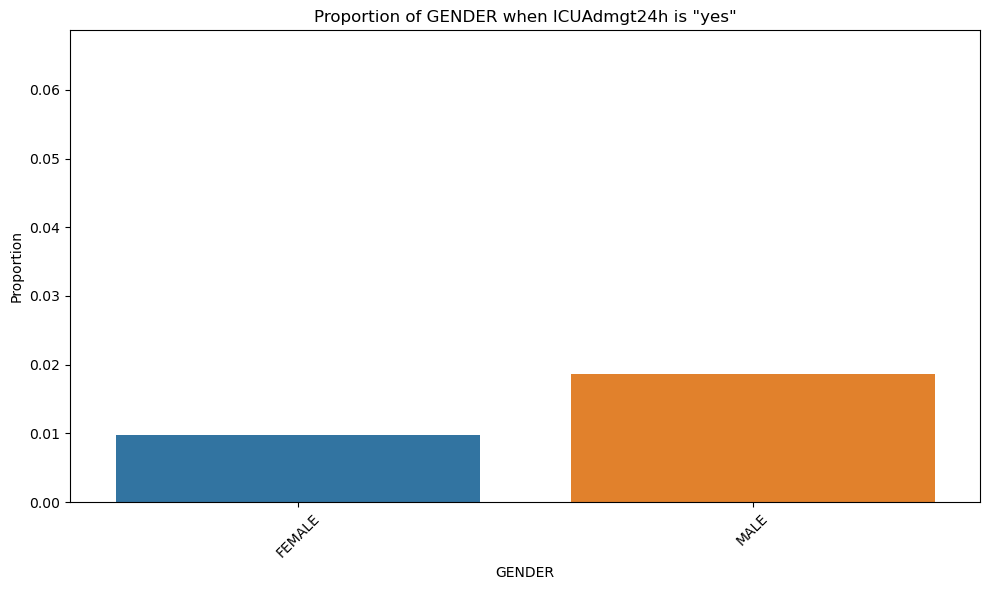

Proportions for Anemia category when ICUAdmgt24h is 'yes':
Anemia category
mild               0.020529
moderate/severe    0.040689
none               0.008445
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


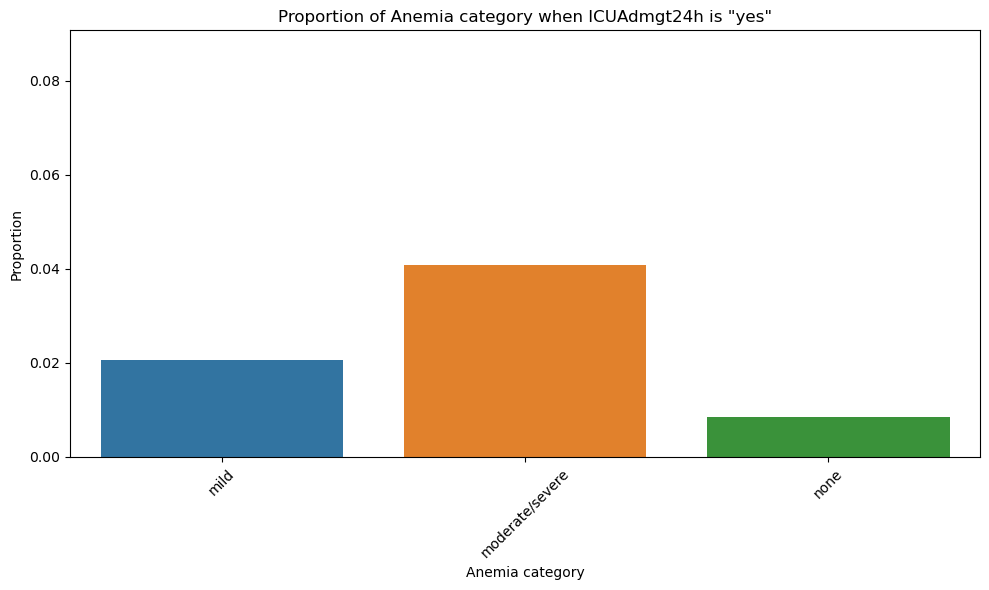

Proportions for AnaestypeCategory when ICUAdmgt24h is 'yes':
AnaestypeCategory
GA    0.015803
RA    0.003904
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


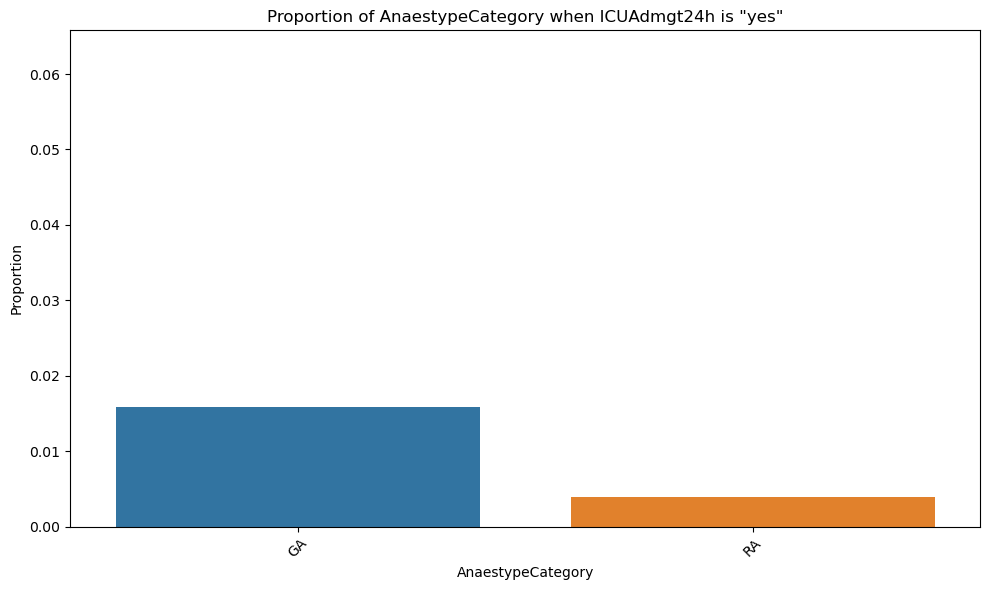

Proportions for PriorityCategory when ICUAdmgt24h is 'yes':
PriorityCategory
Elective     0.009346
Emergency    0.031863
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


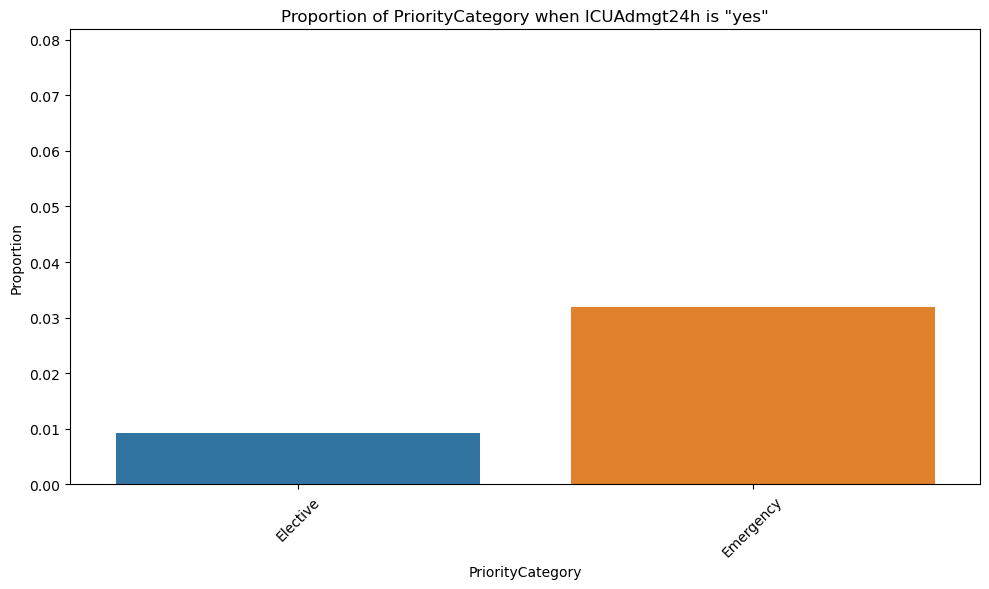

Proportions for TransfusionIntraandpostopCategory when ICUAdmgt24h is 'yes':
TransfusionIntraandpostopCategory
0 units            0.008662
1 unit             0.101982
2 or more units    0.101713
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


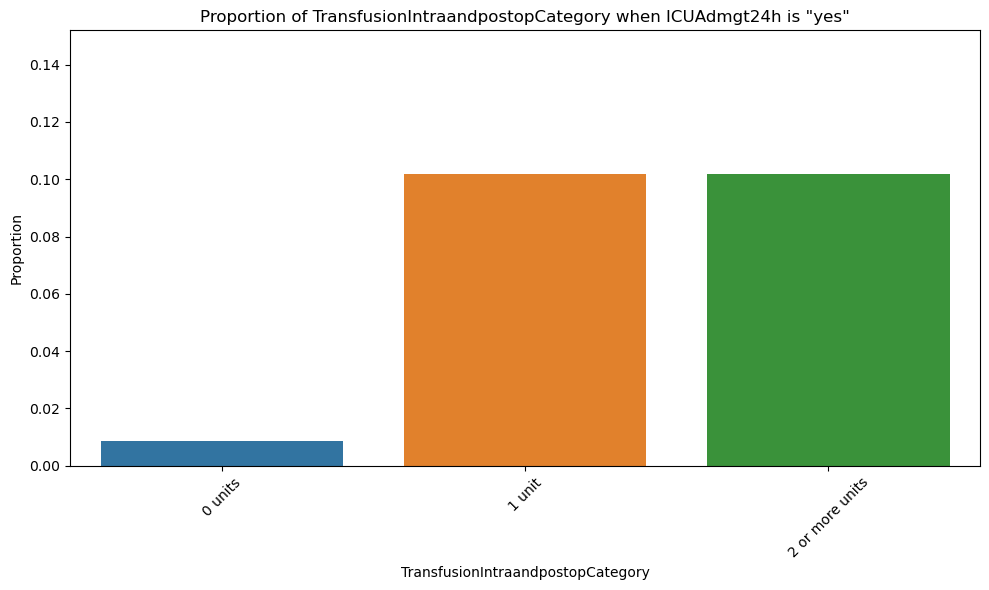

Proportions for AGEcategory when ICUAdmgt24h is 'yes':
AGEcategory
18-29    0.004072
30-49    0.007017
50-64    0.013569
65-74    0.021784
75-84    0.033903
>=85     0.041199
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


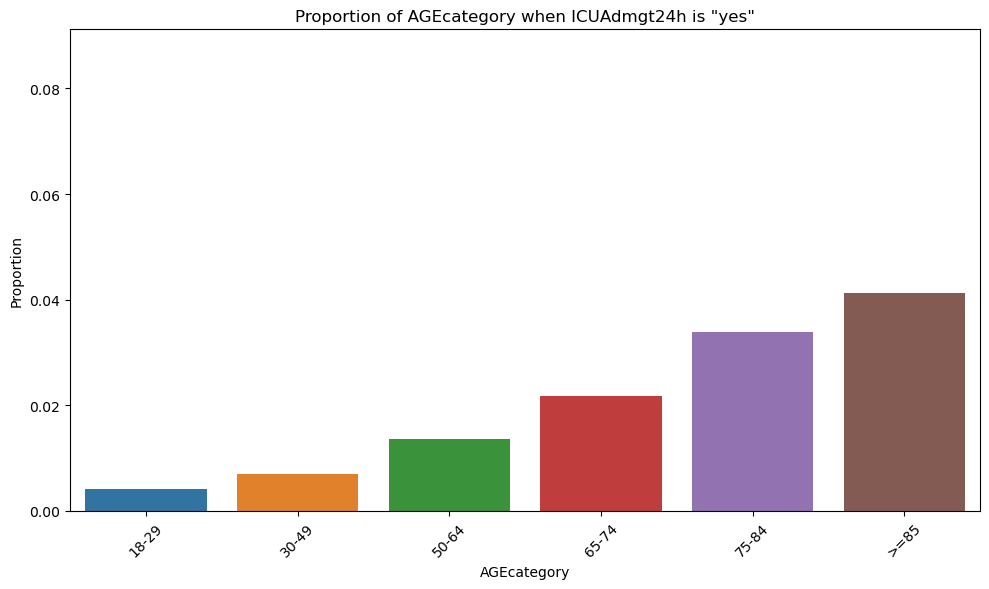

Proportions for SurgRiskCategory when ICUAdmgt24h is 'yes':
SurgRiskCategory
High        0.112037
Low         0.004204
Moderate    0.016533
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


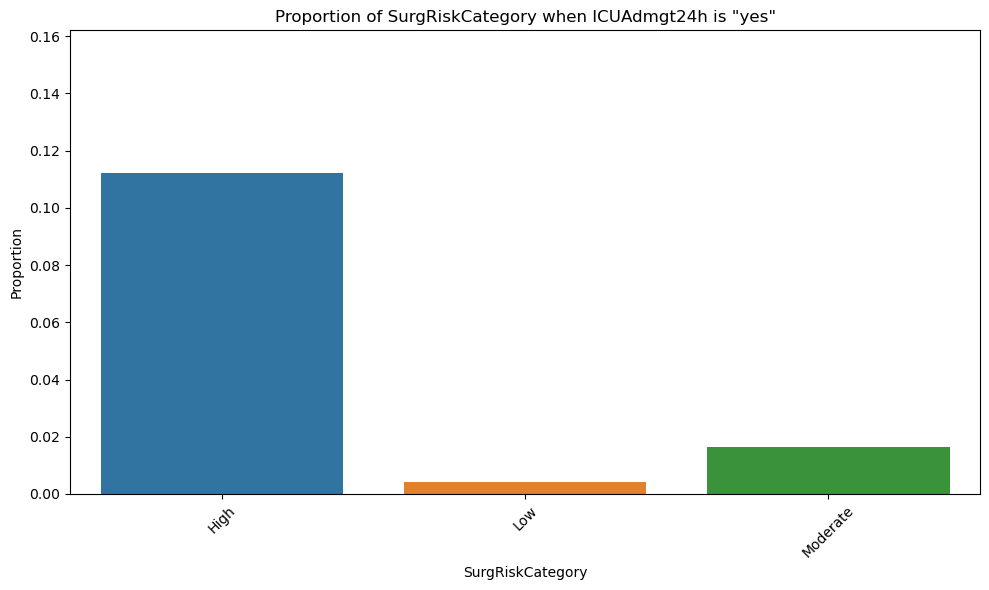

Proportions for RaceCategory when ICUAdmgt24h is 'yes':
RaceCategory
Chinese    0.014061
Indian     0.013480
Malay      0.013476
Others     0.013778
Name: count, dtype: float64


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


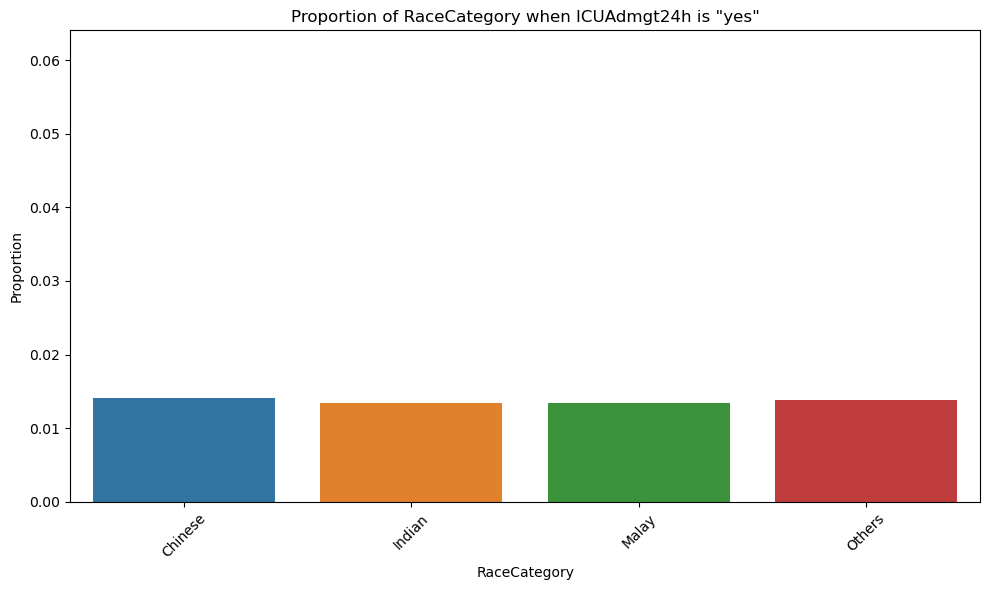

Proportions for CVARCRICategory when ICUAdmgt24h is 'yes':
CVARCRICategory
no     0.013547
yes    0.035645
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


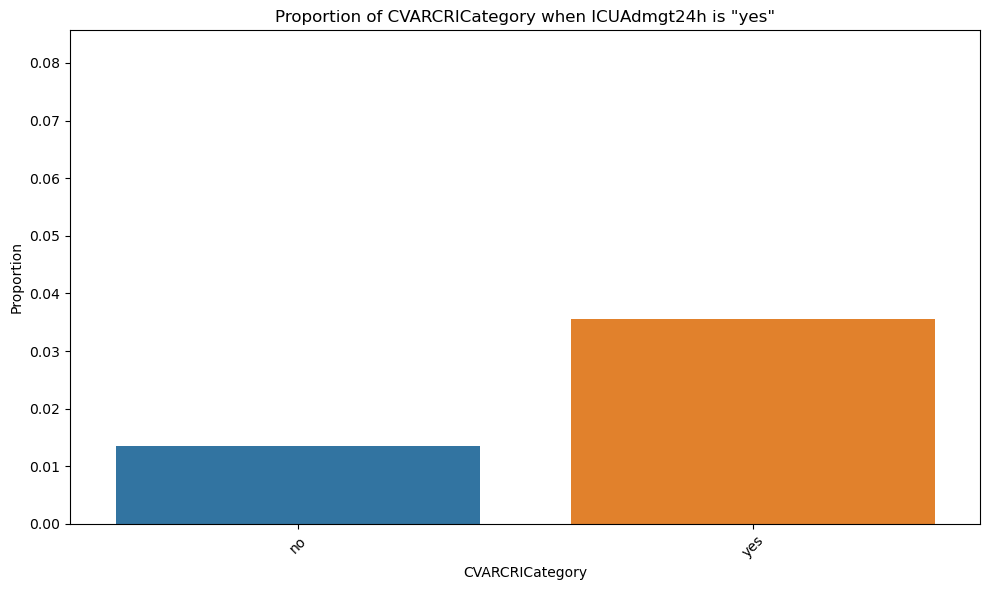

Proportions for IHDRCRICategory when ICUAdmgt24h is 'yes':
IHDRCRICategory
no     0.012399
yes    0.044994
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


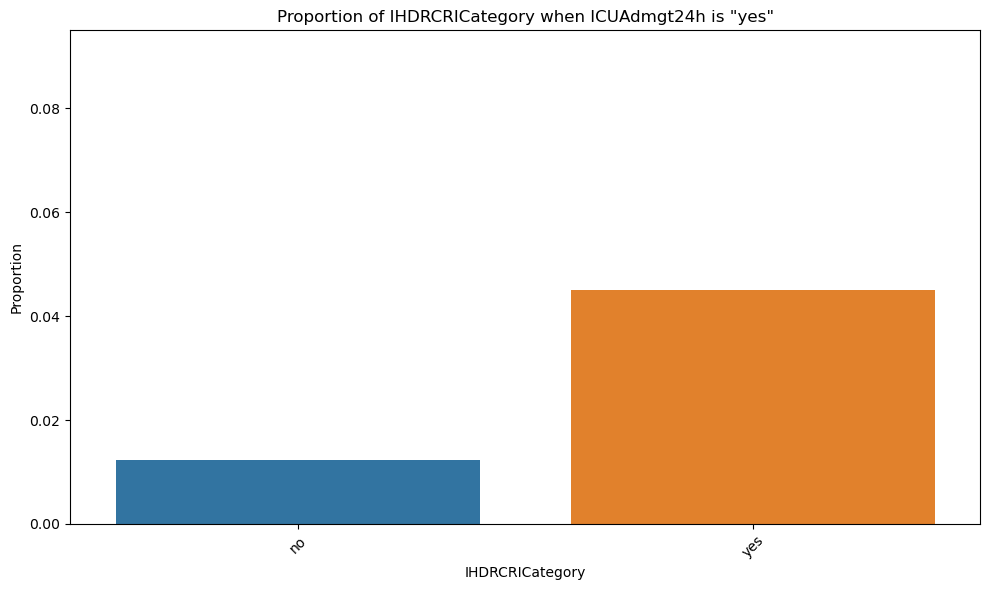

Proportions for CHFRCRICategory when ICUAdmgt24h is 'yes':
CHFRCRICategory
no     0.013378
yes    0.076239
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


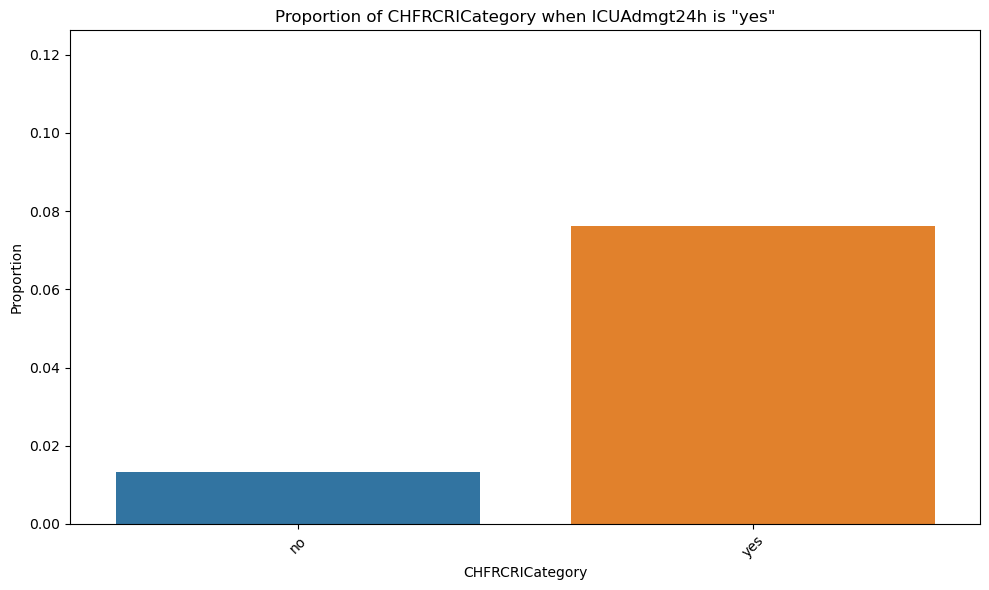

Proportions for DMinsulinRCRICategory when ICUAdmgt24h is 'yes':
DMinsulinRCRICategory
no     0.013584
yes    0.028957
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


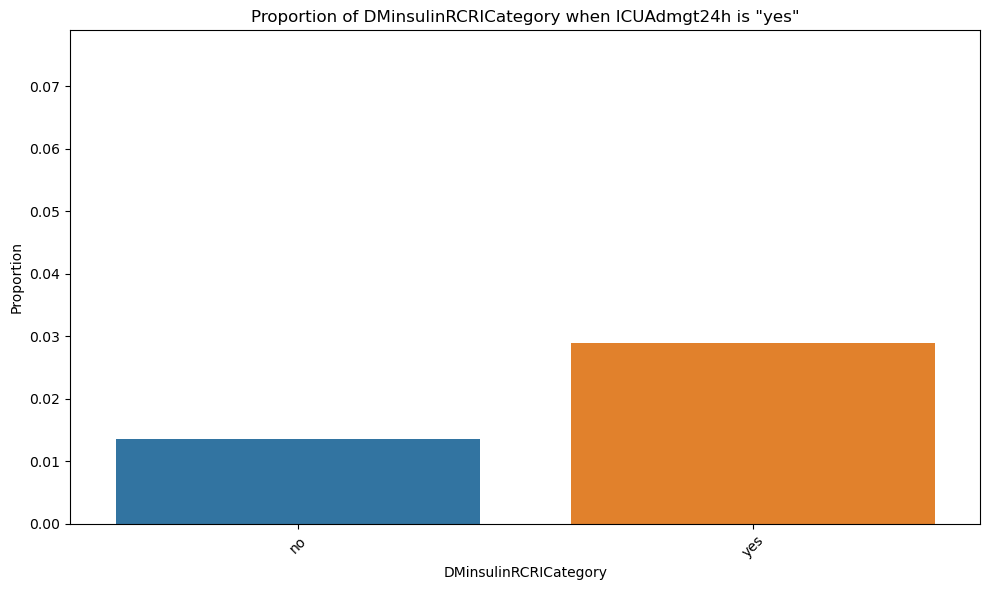

Proportions for CreatinineRCRICategory when ICUAdmgt24h is 'yes':
CreatinineRCRICategory
no     0.012824
yes    0.056529
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


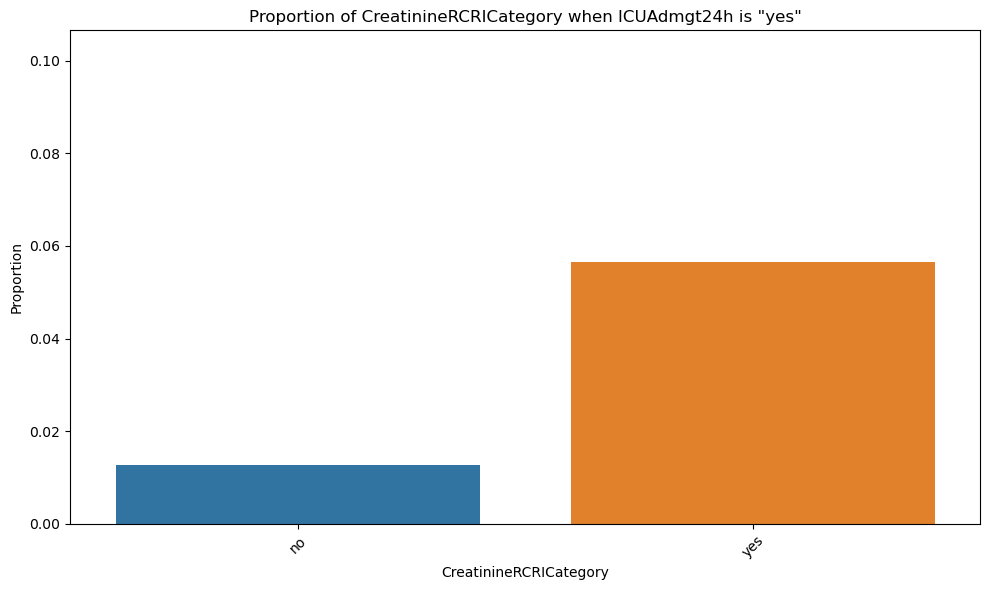

Proportions for GradeofKidneyCategory when ICUAdmgt24h is 'yes':
GradeofKidneyCategory
G1       0.009406
G2       0.012397
G3       0.044975
G4-G5    0.062922
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


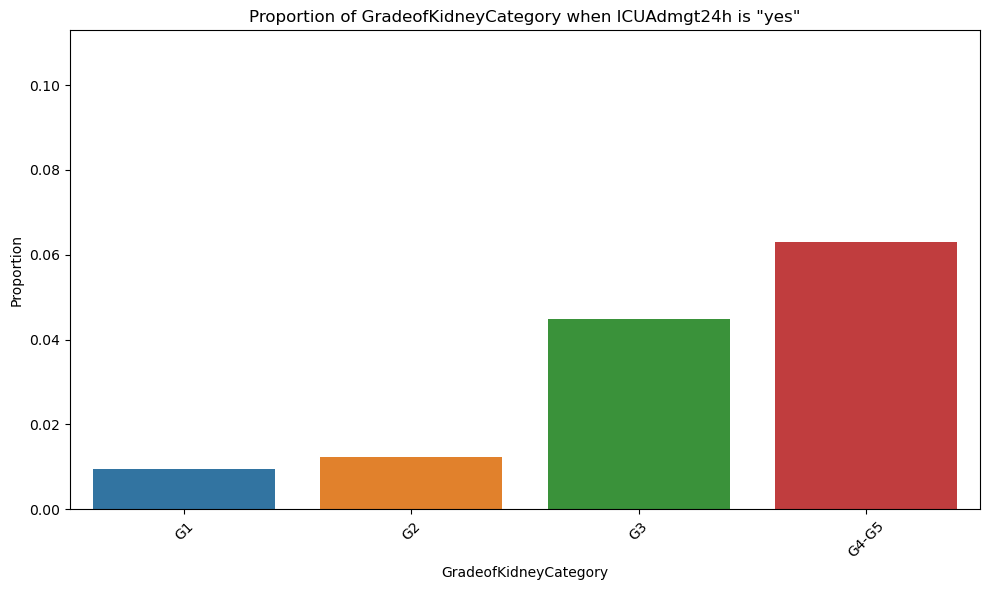

Proportions for RDW15.7 when ICUAdmgt24h is 'yes':
RDW15.7
<= 15.7    0.011884
>15.7      0.033263
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


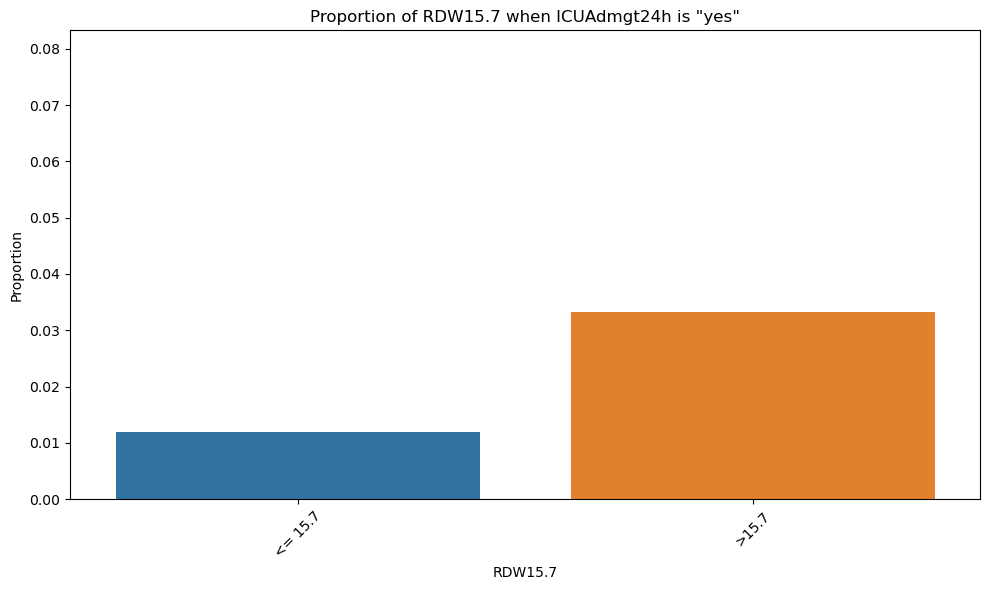

Proportions for ASAcategorybinned when ICUAdmgt24h is 'yes':
ASAcategorybinned
I        0.001724
II       0.006675
III      0.038419
IV-VI    0.241891
Name: count, dtype: float64



/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


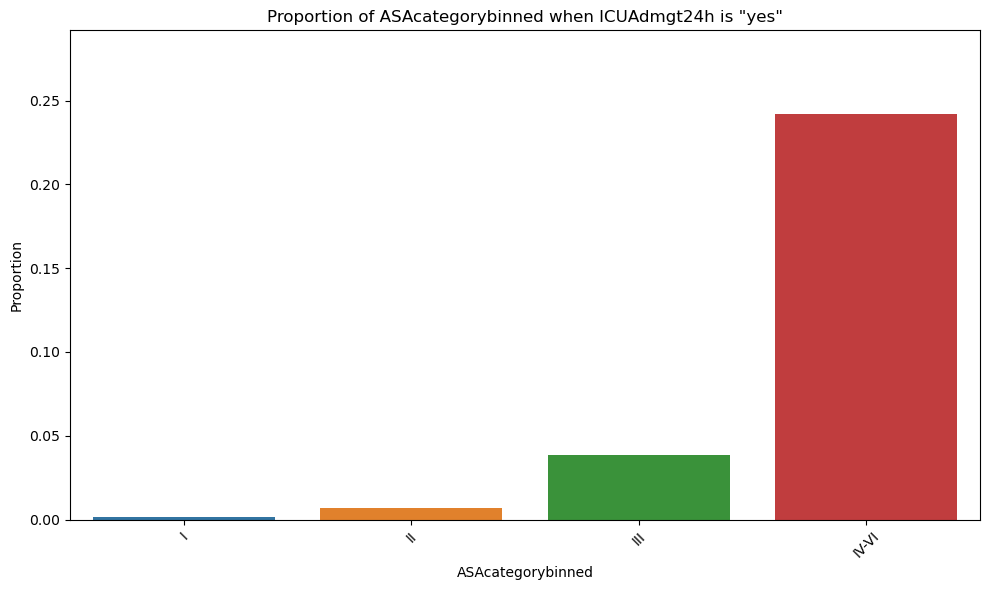

In [27]:
correlation_counts(data, cat_cols)

#### Correlations for Numerical Columns
- Correlation for numerical cols (to drop highly correlated cols for feature reduction)
- Correlations for numerical cols against target variable. 

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Columns')

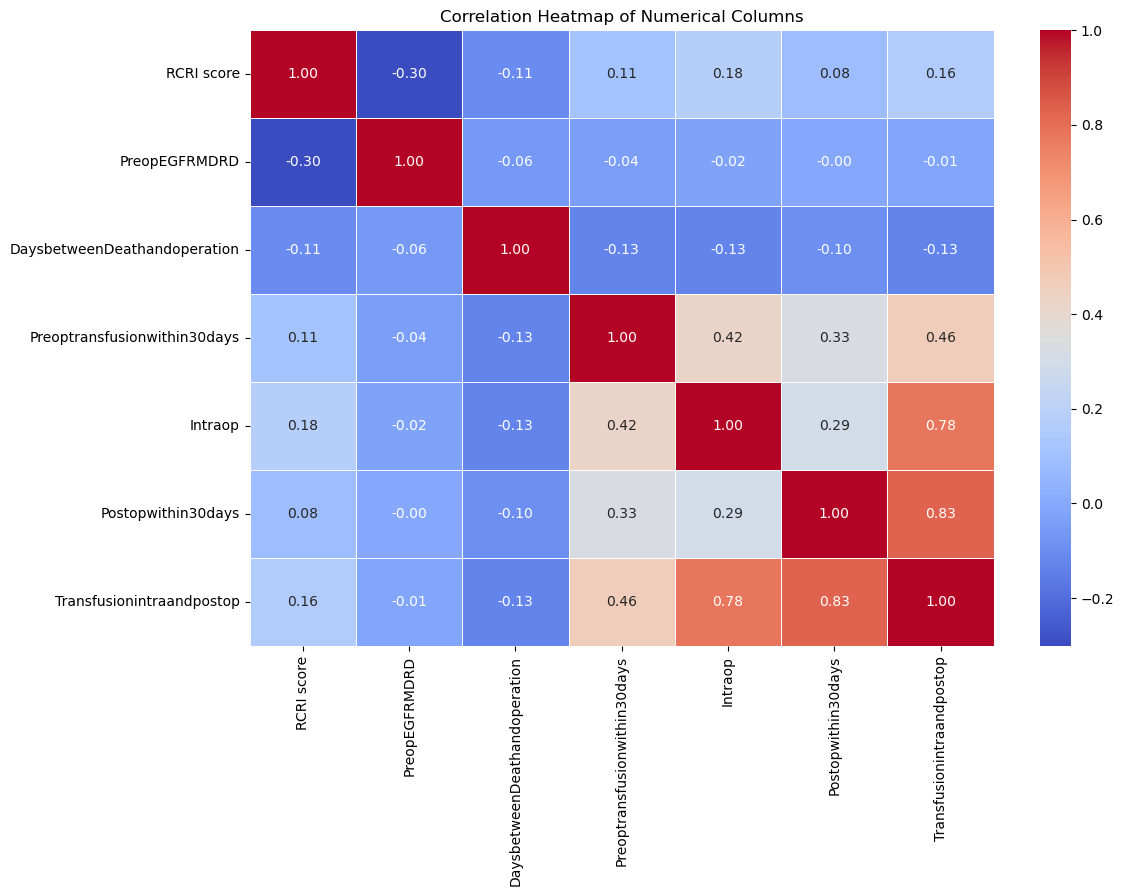

In [33]:
# Compute the correlation matrix
corr_matrix = data[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


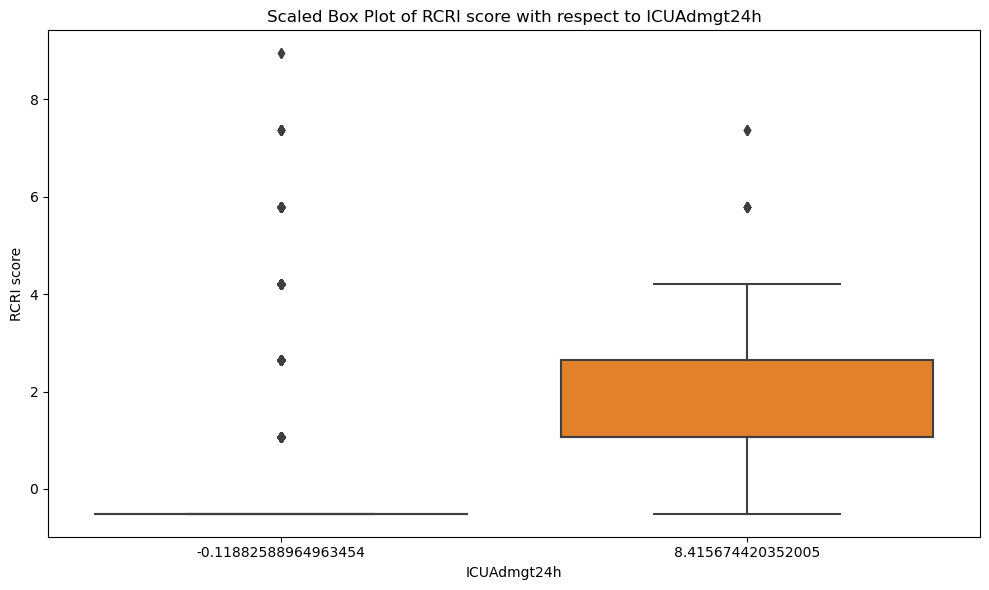

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


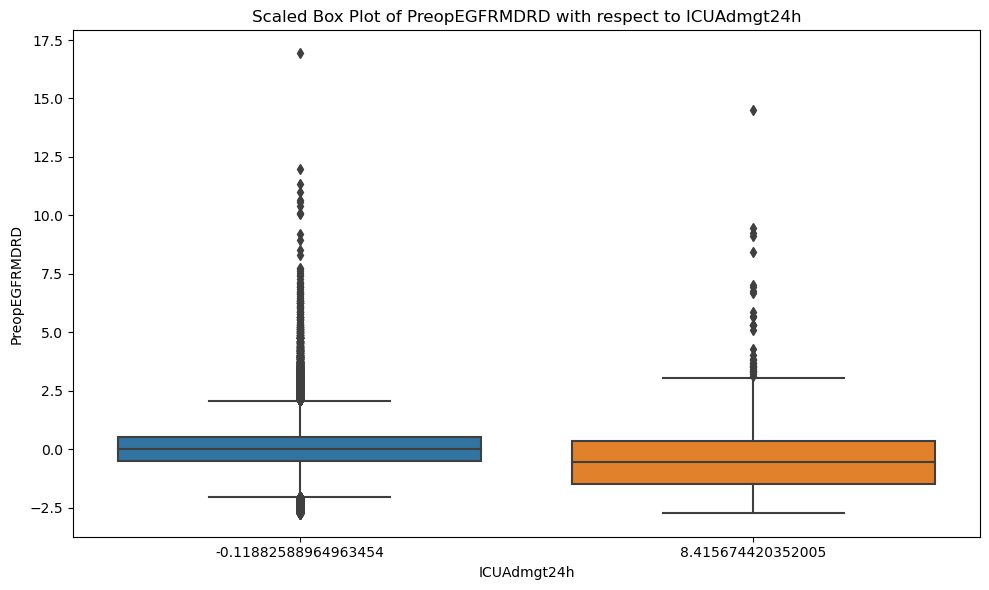

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


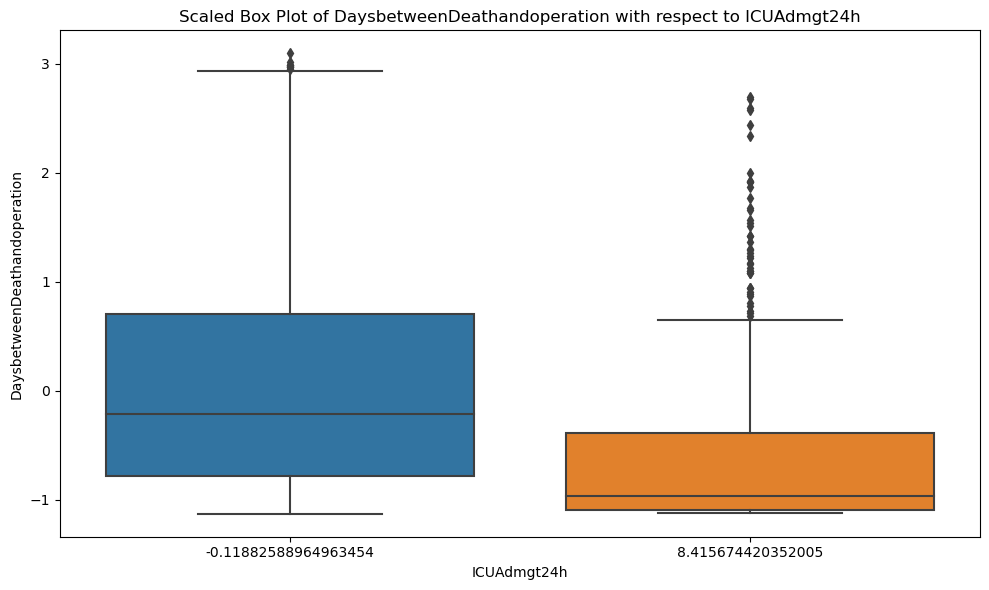

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


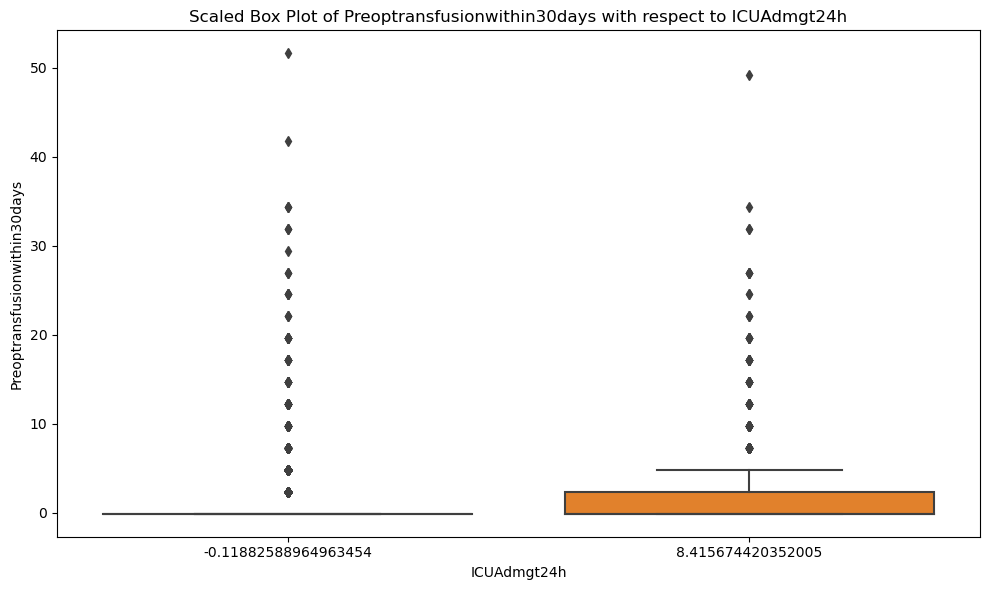

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


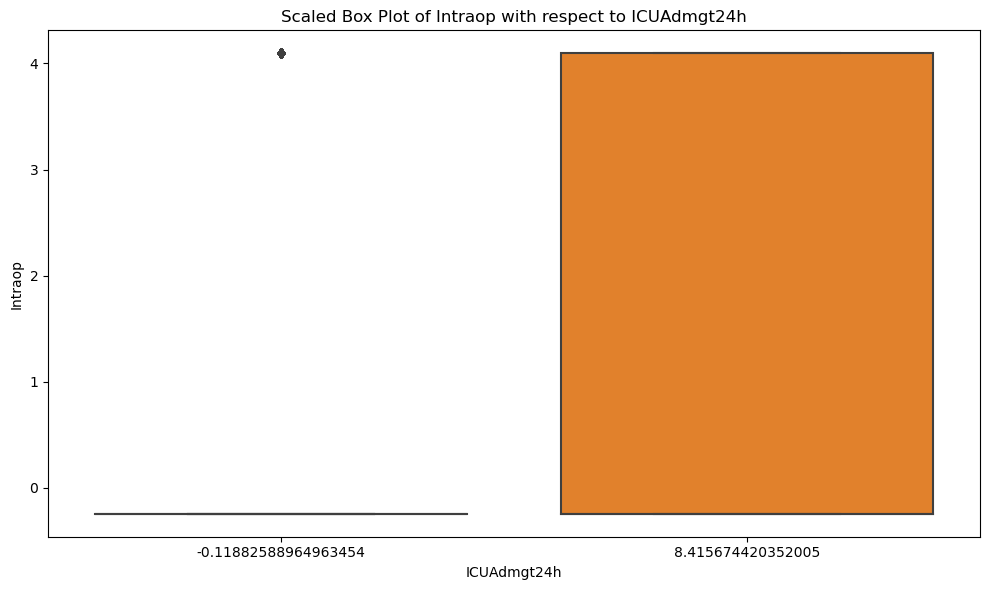

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


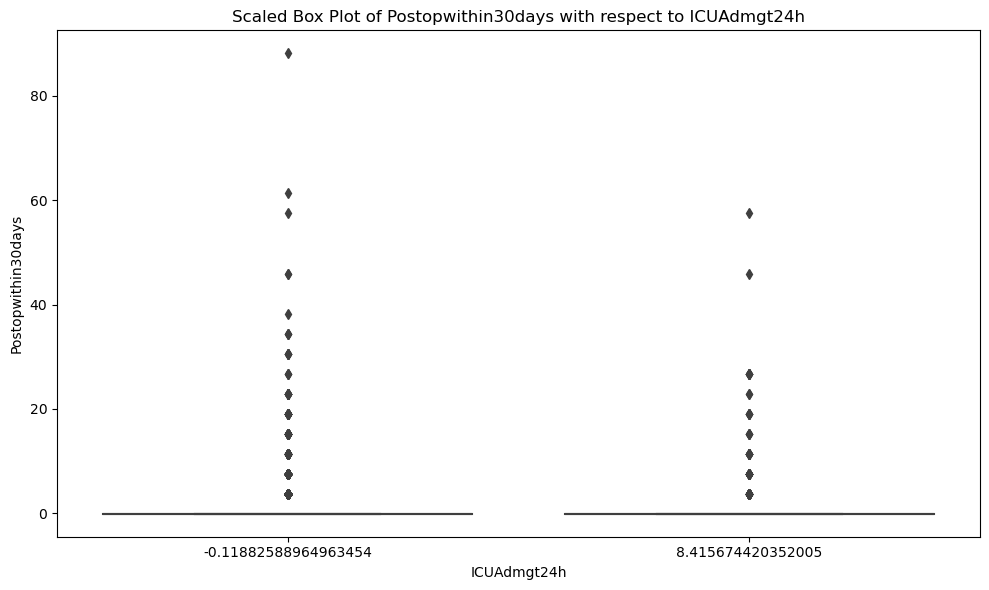

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


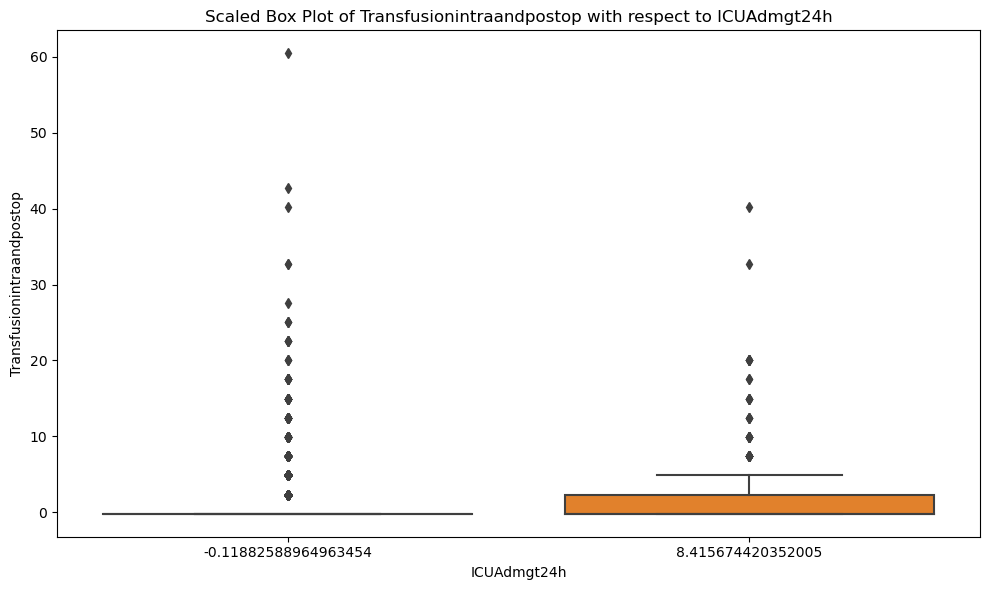

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def visualize_scaled_box_plots(data, target_var='ICUAdmgt24h'):
    """
    Visualize scaled box plots for each numerical column with respect to the target variable.

    Parameters:
    data (pd.DataFrame): The input dataframe.
    target_var (str): The target variable name.

    Returns:
    None
    """
    # Extract numerical columns
    numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
    
    # Remove the target variable from the list of numerical columns
    if target_var in numerical_cols:
        numerical_cols.remove(target_var)
    
    # Ensure the target variable is binary
    if data[target_var].nunique() != 2:
        raise ValueError(f"The target variable {target_var} is not binary.")
    
    # Standard scale the numerical columns (excluding the target variable)
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    
    # Create box plots for each numerical column
    for col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target_var, y=col, data=data)
        plt.title(f'Scaled Box Plot of {col} with respect to {target_var}')
        plt.xlabel(target_var)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
visualize_scaled_box_plots(data, target_var='ICUAdmgt24h')